### Генерация поэзии с помощью нейронных сетей

Основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети.

In [ ]:
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))

cuda device is available


#### 1. Загрузка данных.

In [ ]:
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])


--2024-11-02 20:26:16--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-11-02 20:26:16 (65.1 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста

Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]


Seems fine!


In [ ]:
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))


Пример батча:

In [ ]:
next(generate_chunk())

array([[83, 63, 59, ..., 59, 58,  1],
       [83, 52, 58, ...,  1, 52, 45],
       [83, 47, 63, ..., 59, 47, 73],
       ...,
       [83, 12,  0, ..., 45,  1, 48],
       [83, 61, 64, ...,  1, 51, 53],
       [83, 52, 58, ..., 53,  1, 47]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        embed = self.embedding(x)
        output, hidden = self.rnn(embed, hidden)
        logits = self.fc(output)
        return logits, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, hidden_size).to(device)


In [ ]:
embed_size = 64
hidden_size = 128
vocab_size = num_tokens

char_rnn = VanillaRNN(vocab_size, embed_size, hidden_size).to(device)
optimizer = torch.optim.Adam(char_rnn.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

num_epochs = 10000
loss_history = []
for epoch in range(num_epochs):
    hidden = char_rnn.init_hidden(batch_size)
    epoch_loss = 0.0
    num_batches = 0

    for chunk in generate_chunk():
        inputs = torch.tensor(chunk[:, :-1], dtype=torch.int64).to(device)
        targets = torch.tensor(chunk[:, 1:], dtype=torch.int64).to(device)

        optimizer.zero_grad()
        outputs, hidden = char_rnn(inputs, hidden)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    epoch_loss /= num_batches
    loss_history.append(epoch_loss)

    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [10000/10000], Loss: 1.5757


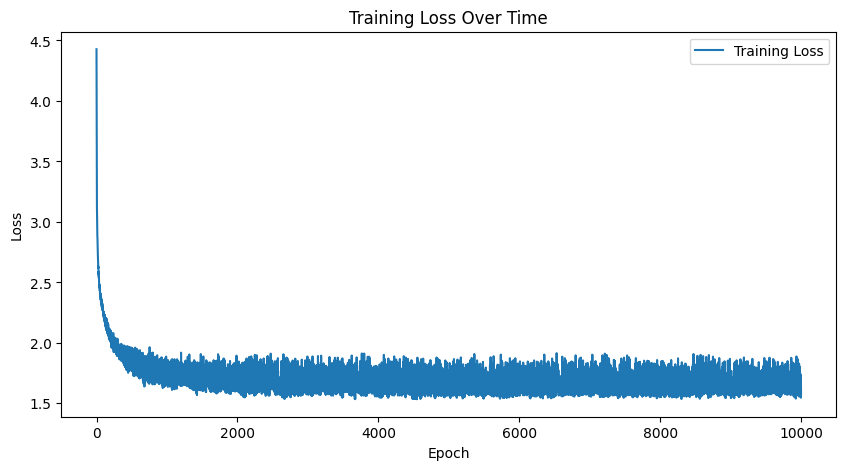

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [ ]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = char_rnn.init_hidden(1)
    
    generated_text = seed_phrase if seed_phrase else ""
    char_rnn.eval()

    with torch.no_grad():
        for _ in range(max_length - len(generated_text)):
            logits, hidden = char_rnn(x_sequence, hidden)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1).squeeze()
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_token[next_char_idx]

            generated_text += next_char
            x_sequence = torch.cat([x_sequence, torch.tensor([[next_char_idx]], dtype=torch.int64).to(device)], dim=1)
            if next_char == '<sos>':
                break

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилее друг обратя,
в браны,
чья,
княю; в тог давно ножке из после детяк изменичас оды домины,
в ростом просужая,
затесе стали с полувно по возший голову
заставить, когу.
убы должен быть, поэта должен лень
на видом, и стрельный,
бледней
тепишно увижай,
всё то же видит, приду…
медремь,
и дамени, и седь нашо души! любил.



xliv

приказал уж и тей вновь
приятно доже черонечно так альбен страшном ольгою крусной как наслева
изот же мне весночие туснигах, быть жар упростит;



In [ ]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


In [ ]:
for temp in np.arange(0.3, 2.1, 0.1):
  print(temp)
  print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

0.3
<sos> мой дядя самых честных правила богом дней замолит – душою
они в послегом еж был нас;
умылкой,
чтоб труды,
безыми грозный,
и сам онегин даже в это полей бутим ровницый девой одежде ж том и почти прель приходь, модный
в коль, мерейценье
летаться не услуга блествате вы, и петурной верно зимашня нежной встренив,
что находит умы,
дву фоными чаще пысковлив понукомый говорил с песнят? к евгением еще в послуй его душа две моды
себя то на бесно и руку
мелькают прошела пораженья,
с пороги приятник лежит 
0.4
<sos> мой дядя самых честных правили томимно, о пладаясь,
перовнопляясь ей.
оголь.
созранком меня бедно другом мужу в постели лишидвен и тетвежным унынные легче ней ленский их дерегом умотил я разлива;
но струйко стали долго слошет,
и стали долгом,
по взор собень как шалодой
и поток, за тотча бедает
и ночко ироже,
кони обедо.



xxiii

что татьяна, владела настило мой кона…
меньших москлы,
я финово,
что долго зимой заботый страшный позражах,
и деревно и родной
в таковенно же жнит м

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
temperature = 0.2
generated_phrases = []

for _ in range(10):
    generated_text = generate_sample(char_rnn, seed_phrase=seed_phrase, max_length=501, temperature=temperature).replace('<sos> ', '')
    generated_phrases.append(generated_text)
    print(generated_text)

мой дядя самых честных правила с ним он не долго слушает не сосед
и слезы не должен, давно с негой станит покоротной
в таня домой странной стол моей привелив,
покором с ней ленский молодой,
в тетной сердца моего с ней лишь без семья
в такого друг, полей
как поверные страстный друг себя в семья
в ней старика страстей сенили в соседом,
подобно и с об жениваньем
на старинных долго привычный другой молодой,
под сень
простосный моей приветляет в семьем старинные в семья,
под ней старинных дома татьян
мой дядя самых честных правила страшно она мог благородной
в темной под сень.



xxxii

вот небраженье,
привычки гремал он отрада домиренный в семья,
под ней старинных долго родной
в темной стал по что ж обор,
и в сеня дома старинных деревено
в семень едет не долго слушает не долго сердце жизнь верно в семья,
под ней старинный франте моей сердечной старины
(на будной
домой сель он в семья,
под мир и мой дверь он верно с ней ленский;
давно с крайки пред ним осталась на собой
в том не модной ветр

In [ ]:
for phrase in generated_phrases:
  print(len(phrase))

500
500
500
500
500
500
500
500
500
500


In [ ]:
#generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]